In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Load data
df = pd.read_excel('./training.xlsx')
df['author_id'].value_counts()

num_unique_authors = df['author_id'].nunique()


Data Cleaning and Feature Engineering

In [17]:
# convert the video_create_date from absolute date to year month day
df['video_create_date'] = pd.to_datetime(df['video_create_date'], unit='s')
df['hour'] = df['video_create_date'].dt.hour
df['video_description'] = df['video_description'].fillna('').astype(str)
df['video_definition'].fillna('unknown', inplace=True)
df['video_format'].fillna('unknown', inplace=True)
df['word_count'] = df['video_description'].apply(lambda x: len(str(x).split()))

C:\Users\sirui\AppData\Local\Temp\ipykernel_25364\3018179917.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['video_definition'].fillna('unknown', inplace=True)
C:\Users\sirui\AppData\Local\Temp\ipykernel_25364\3018179917.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

 Text Preprocessing and Sentiment Analysis

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# preprocess 
nltk.download('wordnet')
nltk.download('stopwords')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = str(text).lower()  
    words = text.split() 
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  
    return ' '.join(words)

df['processed_description'] = df['video_description'].apply(preprocess_text)

# Text sentiment analysis
df['sentiment_polarity'] = df['video_description'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df['sentiment_subjectivity'] = df['video_description'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

# Topic modeling using LDA
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
text_matrix = vectorizer.fit_transform(df['video_description'])


lda = LatentDirichletAllocation(n_components=5, random_state=42)
topic_matrix = lda.fit_transform(text_matrix)
df['topic'] = topic_matrix.argmax(axis=1)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sirui\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sirui\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


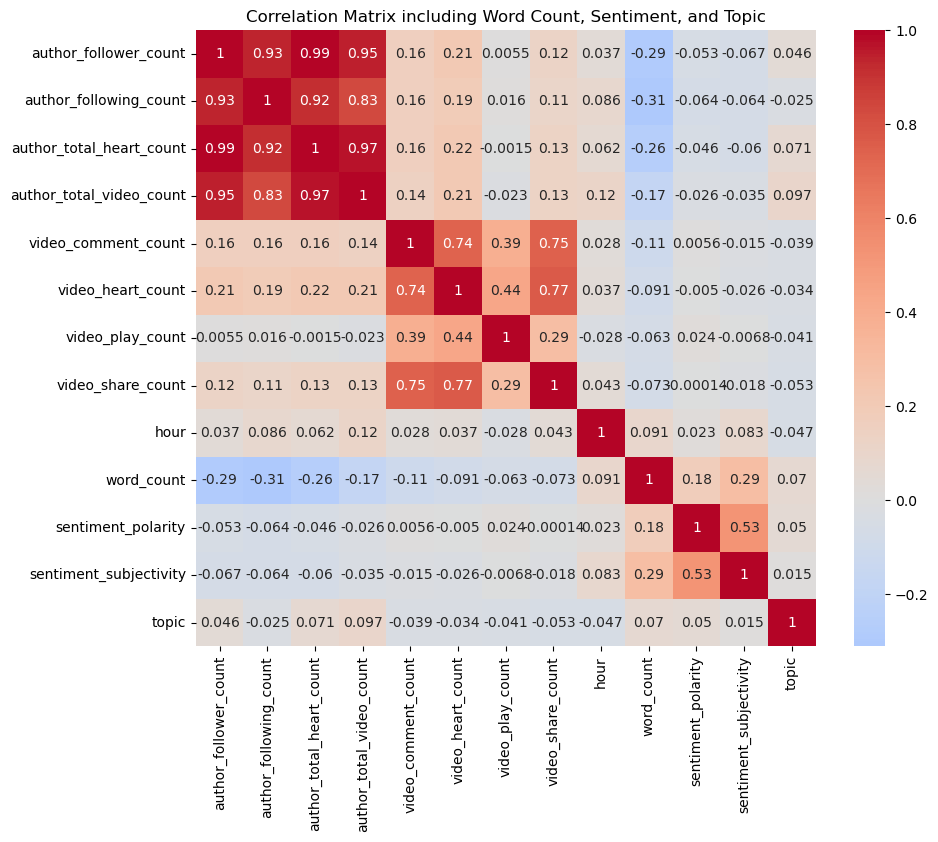

In [19]:
columns_not_in_corr = ['author_id', 'video_id', 'video_description','video_definition',	'video_format']


df_for_corr = df.drop(columns=columns_not_in_corr).select_dtypes(include=['number'])

# correlation matrix
corr = df_for_corr.corr()

# plot the heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix including Word Count, Sentiment, and Topic')
plt.show()

Linear Regression MAE (Log Space): 1.3373368521369855
Linear Regression R² (Log Space): 0.1726092271078783
Random Forest MAE (Log Space): 1.2283406527957434
Random Forest R² (Log Space): 0.24539421368417647
XGBoost MAE (Log Space): 1.3160520150644097
XGBoost R² (Log Space): 0.16876981474278707
Cross-Validated MAE for Linear Regression (Log Space): 1.3437579747659183
Cross-Validated MAE for Random Forest (Log Space): 1.1727383841040442
Cross-Validated MAE for XGBoost (Log Space): 1.249567568455803


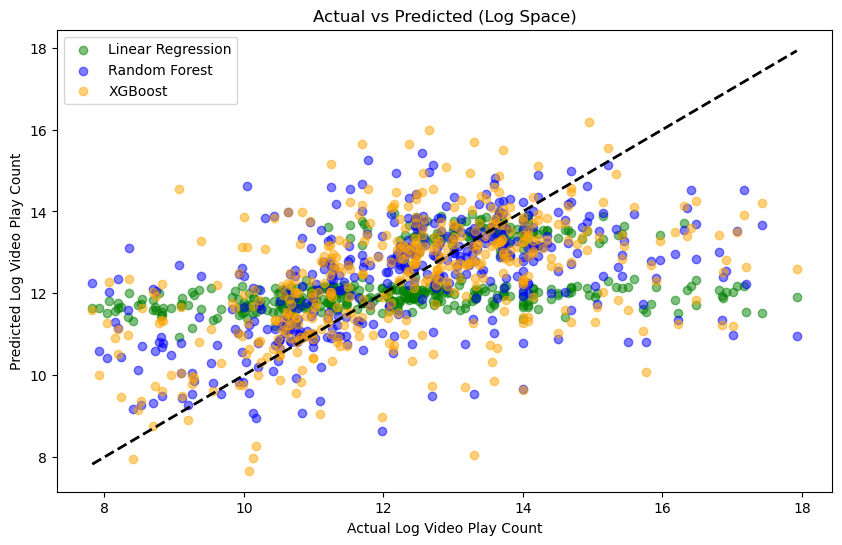

In [20]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


df['log_video_play_count'] = np.log1p(df['video_play_count'])

# selest feature and target, split to train and test set
features = df[['author_follower_count', 'sentiment_polarity', 'sentiment_subjectivity', 'topic', 'word_count', 'hour']]
target = df['log_video_play_count']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# standardlization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Prepare features and target
df['log_video_play_count'] = np.log1p(df['video_play_count'])
features = df[['author_follower_count', 'word_count', 'sentiment_polarity', 'sentiment_subjectivity', 'topic', 'hour']]
target = df['log_video_play_count']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_log_lr = lr_model.predict(X_test_scaled)
mae_lr = mean_absolute_error(y_test, y_pred_log_lr)
r2_lr = r2_score(y_test, y_pred_log_lr)
print(f'Linear Regression MAE (Log Space): {mae_lr}')
print(f'Linear Regression R² (Log Space): {r2_lr}')

# 2. Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_log_rf = rf_model.predict(X_test_scaled)
mae_rf = mean_absolute_error(y_test, y_pred_log_rf)
r2_rf = r2_score(y_test, y_pred_log_rf)
print(f'Random Forest MAE (Log Space): {mae_rf}')
print(f'Random Forest R² (Log Space): {r2_rf}')

# 3. XGBoost Model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train_scaled, y_train)
y_pred_log_xgb = xgb_model.predict(X_test_scaled)
mae_xgb = mean_absolute_error(y_test, y_pred_log_xgb)
r2_xgb = r2_score(y_test, y_pred_log_xgb)
print(f'XGBoost MAE (Log Space): {mae_xgb}')
print(f'XGBoost R² (Log Space): {r2_xgb}')


# Cross-validation for Linear Regression
cv_scores_lr = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_mae_lr = -cv_scores_lr.mean()
print(f"Cross-Validated MAE for Linear Regression (Log Space): {cv_mae_lr}")

# Cross-validation for Random Forest
cv_scores_rf = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_mae_rf = -cv_scores_rf.mean()
print(f"Cross-Validated MAE for Random Forest (Log Space): {cv_mae_rf}")

# Cross-validation for XGBoost
cv_scores_xgb = cross_val_score(xgb_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_mae_xgb = -cv_scores_xgb.mean()
print(f"Cross-Validated MAE for XGBoost (Log Space): {cv_mae_xgb}")



# Visualize Actual vs Predicted values for Linear Regression, Random Forest, and XGBoost
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_log_lr, alpha=0.5, label='Linear Regression', color='green')
plt.scatter(y_test, y_pred_log_rf, alpha=0.5, label='Random Forest', color='blue')
plt.scatter(y_test, y_pred_log_xgb, alpha=0.5, label='XGBoost', color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Log Video Play Count')
plt.ylabel('Predicted Log Video Play Count')
plt.legend()
plt.title('Actual vs Predicted (Log Space)')
plt.show()

Random Forest (Log Space) - MAE: 1.2335069592106709, RMSE: 1.68754525715576, R²: 0.247444381635604
XGBoost (Log Space) - MAE: 1.2988661107119854, RMSE: 1.7685925451000966, R²: 0.17342298382338828
Cross-Validated MAE for Random Forest (Log Space): 1.1746445815288287
Cross-Validated MAE for XGBoost (Log Space): 1.2515412553428817


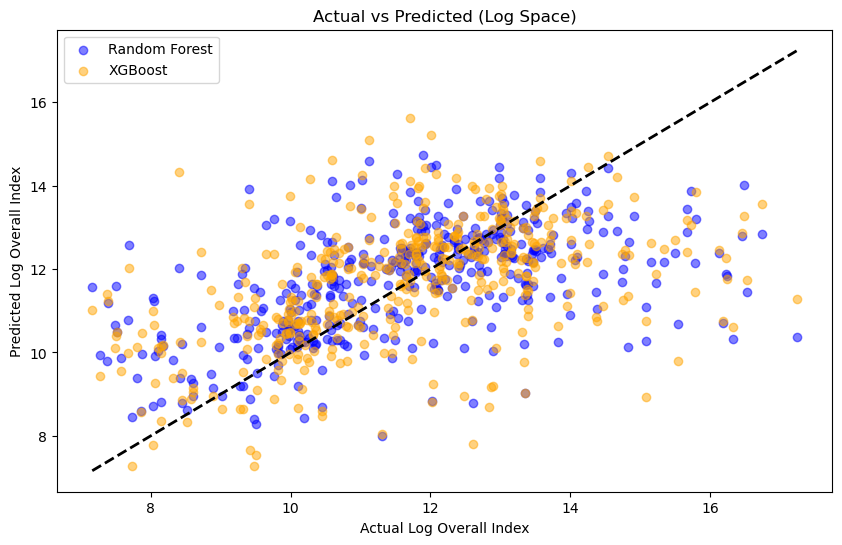

                  Feature  Importance
0   author_follower_count    0.392309
1              word_count    0.210285
5                    hour    0.170972
2      sentiment_polarity    0.085488
4                   topic    0.072823
3  sentiment_subjectivity    0.068123


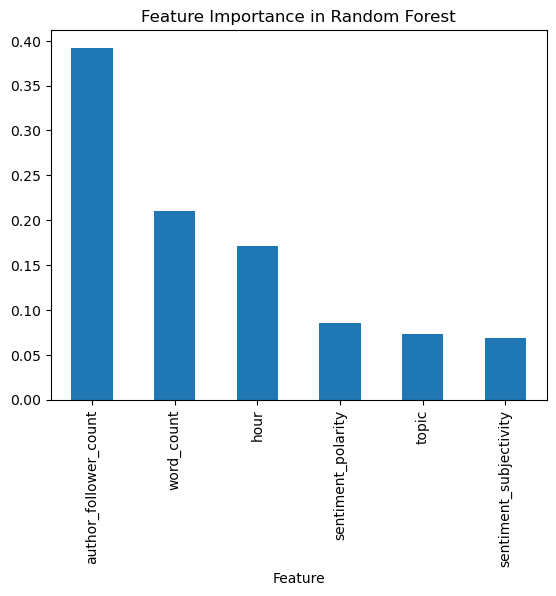

                  Feature  Importance
0   author_follower_count    0.420785
1              word_count    0.128857
2      sentiment_polarity    0.124001
4                   topic    0.120956
5                    hour    0.109884
3  sentiment_subjectivity    0.095517


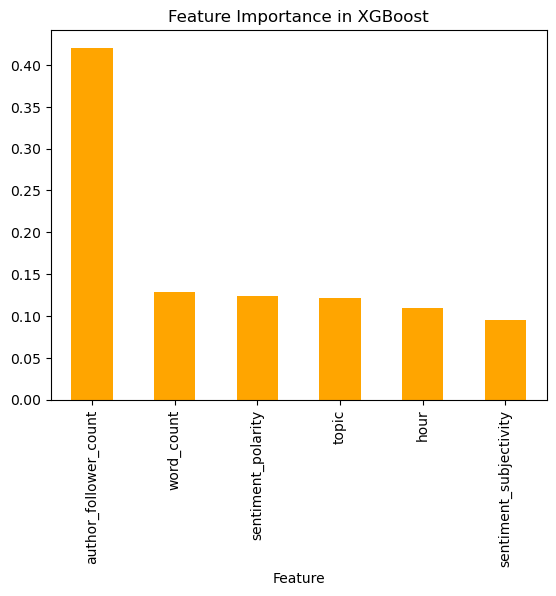

In [21]:
# comprehensive TikTok score

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


df['overall_index'] = (
    df['video_play_count'] * 0.5 +
    df['video_comment_count'] * 0.2 +
    df['video_heart_count'] * 0.2 +
    df['video_share_count'] * 0.1
)

# Apply log transformation to the target variable
df['log_overall_index'] = np.log1p(df['overall_index'])

features = df[['author_follower_count', 'word_count', 'sentiment_polarity',
               'sentiment_subjectivity', 'topic', 'hour']]
target = df['log_overall_index']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_log_rf = rf_model.predict(X_test_scaled)

# XGBoost model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train_scaled, y_train)
y_pred_log_xgb = xgb_model.predict(X_test_scaled)

# mae
mae_rf = mean_absolute_error(y_test, y_pred_log_rf)
mae_xgb = mean_absolute_error(y_test, y_pred_log_xgb)

# rmse
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_log_rf))
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_log_xgb))

# r2
r2_rf = r2_score(y_test, y_pred_log_rf)
r2_xgb = r2_score(y_test, y_pred_log_xgb)

print(f"Random Forest (Log Space) - MAE: {mae_rf}, RMSE: {rmse_rf}, R²: {r2_rf}")
print(f"XGBoost (Log Space) - MAE: {mae_xgb}, RMSE: {rmse_xgb}, R²: {r2_xgb}")

# Cross-validated MAE for both models
cv_scores_rf = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_mae_rf = -cv_scores_rf.mean()

cv_scores_xgb = cross_val_score(xgb_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_mae_xgb = -cv_scores_xgb.mean()

print(f"Cross-Validated MAE for Random Forest (Log Space): {cv_mae_rf}")
print(f"Cross-Validated MAE for XGBoost (Log Space): {cv_mae_xgb}")

# Visualize actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_log_rf, alpha=0.5, label='Random Forest', color='blue')
plt.scatter(y_test, y_pred_log_xgb, alpha=0.5, label='XGBoost', color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Log Overall Index')
plt.ylabel('Predicted Log Overall Index')
plt.legend()
plt.title('Actual vs Predicted (Log Space)')
plt.show()

# Feature importance visualization Random Forest
feature_importances_rf = pd.DataFrame({
    'Feature': features.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances_rf)

# feature importance for Random Forest
feature_importances_rf.plot(kind='bar', x='Feature', y='Importance', legend=False)
plt.title('Feature Importance in Random Forest')
plt.show()

# Feature importance visualization XGBoost
feature_importances_xgb = pd.DataFrame({
    'Feature': features.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances_xgb)

# feature importance for XGBoost
feature_importances_xgb.plot(kind='bar', x='Feature', y='Importance', legend=False, color='orange')
plt.title('Feature Importance in XGBoost')
plt.show()
